In [339]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.interpolate import interp1d
from glob import glob
import pandas as pd
import astropy.units as u

In [340]:
x = lambda Egamma, Mbh : Egamma / (1058 * 1e10 / Mbh)

# parameterization in Eq . (31 - 34) of 1510.04372, all in GeV^-1 sec^-1
A = 6.339 * 1e23
B = 1.1367 * 1e24
thetaS = lambda u : .5 * (1 + np.tanh(10 * u))

def frag(Egamma, Mbh):
    return (
        A * x(Egamma, Mbh) * ( 1 - thetaS( x(Egamma, Mbh) - 0.3 ) ) + 
        B * np.exp( -x(Egamma, Mbh) ) * thetaS( x(Egamma, Mbh) - 0.3 ) / ( x(Egamma, Mbh) * ( x(Egamma, Mbh) + 1 ) ) 
    )

def Ffunc(y):
    val = np.exp( -.0962 - 1.982 * (np.log(y) - 1.908) * (1 + np.tanh(20 * (np.log(y) - 1.908)) ))
    val[np.where(y >= 2)] = 1
    return val

def dir(Egamma, Mbh):
    return (
        1.13 * 1e19 * x(Egamma, Mbh)**6 / ( (np.exp(x(Egamma, Mbh)) - 1) * Ffunc(x(Egamma, Mbh)) )
    )

Mbh = lambda time : 1e10 * (time/407)**(1/3)

photon_flux = lambda time, Egamma: dir(Egamma, Mbh(time)) + frag(Egamma, Mbh(time))

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


Text(0, 0.5, 'Photon counts (GeV$^{-1}$ s$^{-1}$)')

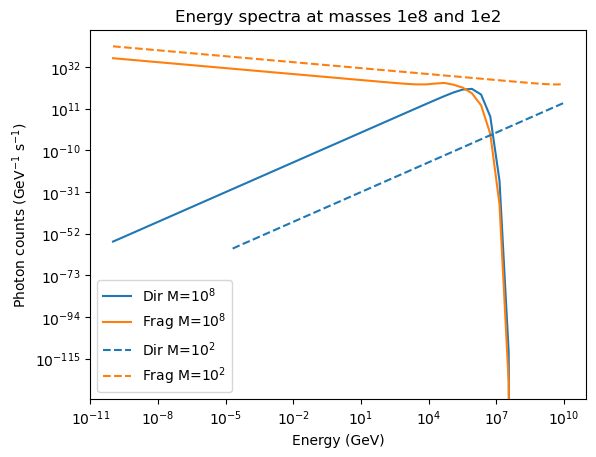

In [341]:
E = np.logspace(-10, 10)
plt.loglog( E, dir(E,1e8), label = r'Dir M=$10^8$' )
plt.loglog( E, frag(E,1e8), label = r'Frag M=$10^8$' )
plt.loglog( E, dir(E,1e2), '--', color = 'C0', label = r'Dir M=$10^2$' )
plt.loglog( E, frag(E,1e2), '--', color = 'C1', label = r'Frag M=$10^2$' )
plt.legend()

plt.title('Energy spectra at masses 1e8 and 1e2')

plt.xlabel('Energy (GeV)')
plt.ylabel(r'Photon counts (GeV$^{-1}$ s$^{-1}$)')

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp


Text(0, 0.5, 'Photon counts (s$^{-1}$)')

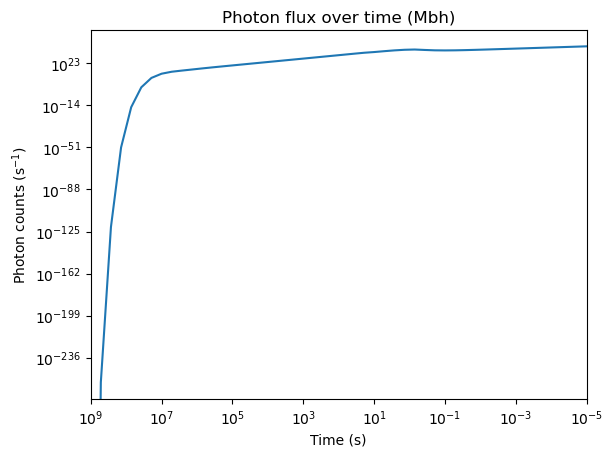

In [342]:
Emin = 1e-6
Emax = 1e11
Erange = np.logspace(-6, 11)

fluxdt = [ simps(photon_flux(Erange, time), x = Erange ) for time in np.logspace(9, -5) ]

plt.loglog(np.logspace(9, -5), fluxdt, label = r'$\frac{d\Phi}{dt}$')

plt.xlim(1e9,1e-5)
plt.title('Photon flux over time (Mbh)')
plt.xlabel('Time (s)')
plt.ylabel(r'Photon counts (s$^{-1}$)')

In [343]:
EffectiveAreas = {
    detector[:-4].split('/')[-1] : 
    pd.read_csv(detector, sep=' ', header=None, names = ['E GeV', 'Aeff cm2'])
    for detector in glob('./EffectiveAreas/*')
    }


def N_S(Egamma:list, time, Aeff, distance):
    fluxdt = [ simps( photon_flux(Egamma, t) * Aeff(Egamma) / (4*3.14159 * distance**2), x = Egamma) for t in list(time) ]
    return fluxdt

instantaneous_N_S = lambda Egamma, time, Aeff, distance : simps( photon_flux(Egamma, time) * Aeff(Egamma), x = Egamma) / (4*3.14159 * distance**2)

Text(0, 0.5, 'Effective Area (m$^2$)')

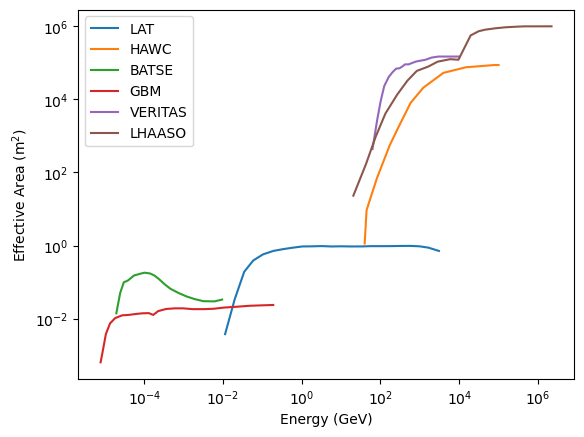

In [344]:
for Aeff in EffectiveAreas:
    E = EffectiveAreas[Aeff]['E GeV']
    plt.loglog(E, interp1d(x = E, y = EffectiveAreas[Aeff]['Aeff cm2'] * (u.cm.to('m'))**2, kind='linear', bounds_error = False, fill_value = 0.)(E), label = Aeff)

plt.legend()
plt.xlabel('Energy (GeV)')
plt.ylabel('Effective Area (m$^2$)')

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp


(1000000000.0, 0.001)

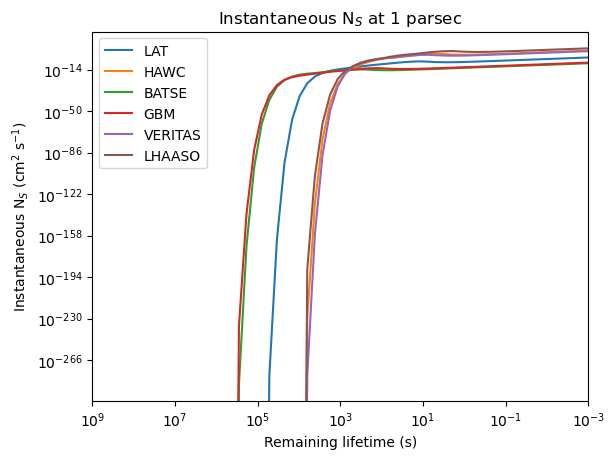

In [345]:
Erange = np.logspace(-6, 7)

for detector in EffectiveAreas:
    Aeff = interp1d( x = EffectiveAreas[detector]['E GeV'], y = EffectiveAreas[detector]['Aeff cm2'], kind='linear', bounds_error = False, fill_value = 0. )

    plt.loglog(np.logspace(-3,6), [instantaneous_N_S( Erange, t, Aeff, 1 * u.pc.to('cm') ) for t in np.logspace(-3, 9)] , label = detector)

plt.legend()
plt.xlabel('Remaining lifetime (s)')
plt.ylabel('Instantaneous N$_S$ (cm$^2$ s$^{-1}$)')
plt.title('Instantaneous N$_S$ at 1 parsec')
plt.xlim(1e9, 1e-3)

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp


Text(0.5, 1.0, 'Maximum distance that $N_S$ > 10 ph (-- incl. d$\\Omega$)')

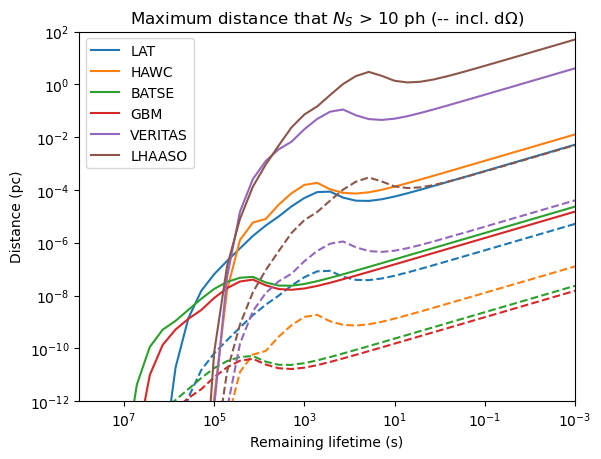

In [346]:
time = np.logspace(9, -5)
distances = np.logspace(-4, 1)

Eranges = { # (Emin, Emax) in log GeV
    'LAT': (-2, 3),
    'GBM': (-4, -2),
    'BATSE': (-5, -2),
    'HAWC': (1, 2),
    'VERITAS': (1, 4),
    'LHAASO': (1,6)
}

dOm = {
    'LAT': 1e-3,
    'GBM': 1e-3,
    'BATSE': 1e-3,
    'HAWC': 1e-5,
    'VERITAS': 1e-5,
    'LHAASO': 1e-4
}

for i,detector in enumerate(EffectiveAreas):
    Erange = np.logspace(Eranges[detector][0], Eranges[detector][1])

    Aeff = interp1d( x = EffectiveAreas[detector]['E GeV'], y = EffectiveAreas[detector]['Aeff cm2'], kind='linear', bounds_error = False, fill_value = 0. )

    det_break = []
    for t in time: 
        # Solve directly for the d contour (set d=1 and then calculate-back d = sqrt( n_s / (4pi * 10) )
        det_break.append( np.sqrt( instantaneous_N_S( Erange, t, Aeff, 1 ) / 10 ) * u.cm.to('pc') )

    det_break = np.array(det_break)

    plt.loglog(time, det_break, color = 'C%s'%i, label = detector)
    plt.loglog(time, det_break * dOm[detector], '--', color = 'C%s'%i)

#plt.axhline(10, linestyle = '--', color = 'black', label = '10 photons')
plt.legend()
plt.xlabel('Remaining lifetime (s)')
plt.ylabel('Distance (pc)')
plt.ylim(1e-12, 1e2)
plt.xlim(1e8, 1e-3)
plt.title('Maximum distance that $N_S$ > 10 ph (-- incl. d$\Omega$)')

In [347]:
Ebkg = lambda E: 1.4*1e-6 * E**(-2.1) #cm-2 GeV-1 s-1 sr-1

def N_B(Egamma, time, Aeff, dOm):
    return time * simps(Aeff(Egamma) * dOm * Ebkg(Egamma), x = Egamma)

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp


Text(0.5, 1.0, '$\\sigma$ signal over background wrt. time, at 1pc')

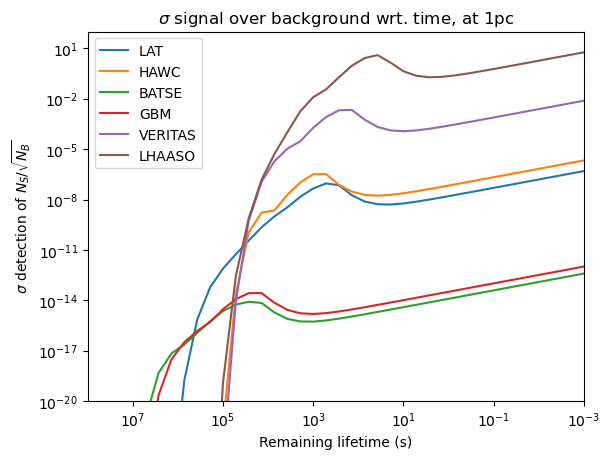

In [348]:
for i,detector in enumerate(EffectiveAreas):
    Erange = np.logspace(Eranges[detector][0], Eranges[detector][1])
    Om = dOm[detector]
    Aeff = interp1d( x = EffectiveAreas[detector]['E GeV'], y = EffectiveAreas[detector]['Aeff cm2'], kind='linear', bounds_error = False, fill_value = 0. )

    signal = time * np.array(N_S(Erange, time, Aeff, 1*u.pc.to('cm'))) * Om
    background = np.array(N_B(Erange, time, Aeff, Om))

    plt.loglog(time, signal/np.sqrt(background), color = 'C%s'%i, label = detector)

#plt.axhline(10, linestyle = '--', color = 'black', label = '10 photons')
plt.legend()
plt.xlabel('Remaining lifetime (s)')
plt.ylabel(r'$\sigma$ detection of $N_S/\sqrt{N_B}$')
plt.xlim(1e8, 1e-3)
plt.ylim(1e-20,1e2)
plt.title('$\sigma$ signal over background wrt. time, at 1pc')

In [349]:
def detN(Egamma, time, Aeff, dOm):
    fluxdt = [ simps(dOm * Aeff(Egamma) * photon_flux(Egamma, t), x = Egamma) for t in time ]
    return simps(fluxdt, x = time)

def detSN(sig, Egamma, Aeff, dOm, tau):
    noise = np.sqrt( min( 3e7, tau ) * simps(dOm * Aeff(Egamma) * Ebkg(Egamma), x = Egamma) )
    return sig/noise

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/scipy/integrate/_quadrature.py:372: RuntimeWarning: invalid value encountered in true_divide
  h0divh1 = h0 / h1
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/scipy/integrate/_quadrature.py:374: RuntimeWarning: invalid value encountered in true_divide
  y[slice1]*hsum*hsum/hprod +
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/scipy/integrate/_quadrature.py:372: RuntimeWarning: invalid value encountered in true_divide
  h0divh1 = h0 / h1
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/scipy/integrate/_quadrature.py:374: RuntimeWarning: invalid value encountered in true_divide
  y[slice1]*hsum*hsum/hprod +
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:21: Runtim

(100000000.0, 0.1)

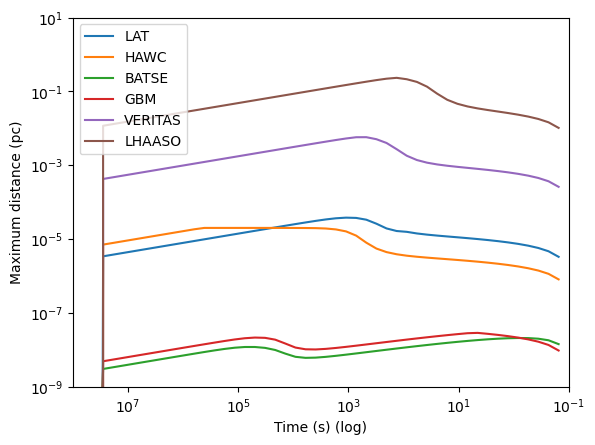

In [350]:
for i,detector in enumerate(EffectiveAreas):
    Erange = np.logspace(Eranges[detector][0], Eranges[detector][1])
    Om = dOm[detector]
    Aeff = interp1d( x = EffectiveAreas[detector]['E GeV'], y = EffectiveAreas[detector]['Aeff cm2'], kind='linear', bounds_error = False, fill_value = 0. )

    remaining_lifetime = np.logspace(-1, 8)

    max_dist = []
    for tau in remaining_lifetime:
        time = np.logspace( np.log10( max(1e-1, tau - 3e7) ), np.log10(tau))
        N = detN(Erange, time, Aeff, Om) / (4 * 3.14159) # let d=1 to just cancel out
        Ns = detSN(N, Erange, Aeff, Om, tau) / (4 * 3.14159)
        max_dist.append( min(
            np.sqrt( N/10 ) * u.cm.to('pc'),
            np.sqrt( Ns/5 ) * u.cm.to('pc'),
                ) )
    
    plt.loglog(remaining_lifetime, max_dist, color = 'C%s'%i, label = detector)

plt.legend()
plt.xlabel('Time (s) (log)')
plt.ylabel('Maximum distance (pc)')
plt.ylim(1e-9, 1e1)
plt.xlim(1e8, 1e-1)
    
    

In [303]:
def logNormalMassFcn(sigma, Mstar, M):
    return np.exp(
        -np.log(M/Mstar)**2 / (2 * sigma**2)
    ) / (np.sqrt(2 * 3.14159) * sigma * M)

fPBH = 1e-8
gramsperGeV = 1 / (5.6095886*1e23)
rhoDM = 0.4 * gramsperGeV * (u.pc.to('cm')**3)

def numberDensity(mass, distance, Mstar = 1e10, sigma = 1):
    return  logNormalMassFcn(sigma, Mstar, mass) * rhoDM * fPBH * 4 / 3 * 3.14159 * distance**3

Text(0.5, 1.0, 'Log PBH number density with log normal mass function')

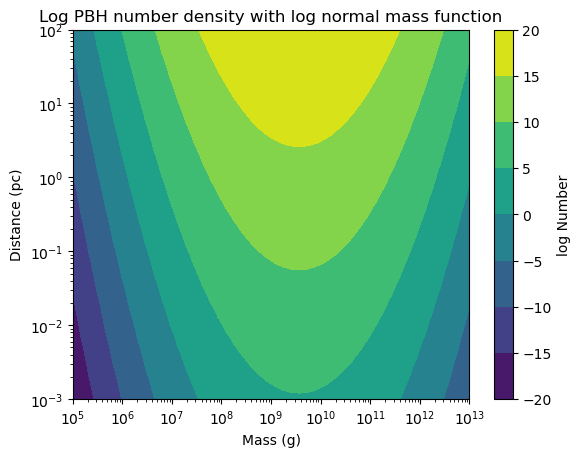

In [336]:
mass = np.logspace(5,13)
distance = np.logspace(-3,2)
M,D = np.meshgrid(mass, distance)

sigma = 1
Mstar = 1e10

plt.contourf( M, D, np.log10(numberDensity(M,D,Mstar,sigma)) )#, levels = [-15, -10, -5, 0, 5, 10, 15] )
cb = plt.colorbar(label = 'log Number')
plt.xlabel('Mass (g)')
plt.ylabel('Distance (pc)')
plt.yscale('log')
plt.xscale('log')
plt.title('Log PBH number density with log normal mass function')

In [307]:
alpha = lambda M: 4 * 1e-4 * M**2

def evolvedMassFunction(sigma, Mstar, M, time):
    return np.exp(
        -np.log( (M**3 + 3*alpha(M) * time)**(1/3) /Mstar)**2 / (2 * sigma**2)
    ) / (np.sqrt(2 * 3.14159) * sigma * (M**3 + 3*alpha(M) * time)**(1/3) * (M**3 / (M**3 + 3*alpha(M) * time)))

def evolvedNumberDensity(mass, distance, Mstar = 1e10, sigma = 1, age_of_universe = 4 * 1e9 * 365 * 24 * 60 * 60):
    return  evolvedMassFunction(sigma, Mstar, mass, age_of_universe) * rhoDM * fPBH * 4 / 3 * 3.14159 * distance**3

Text(0.5, 1.0, 'Log PBH number density with evolved mass function')

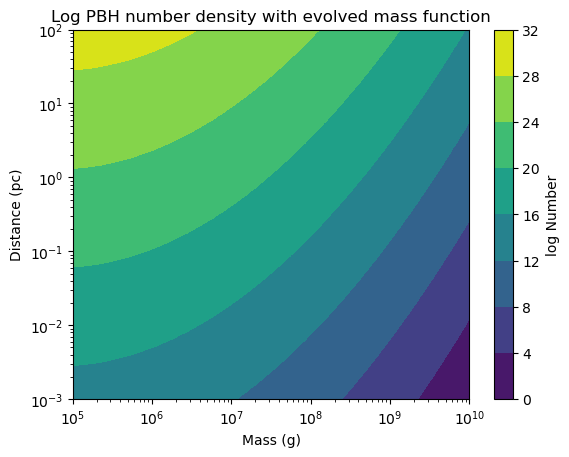

In [335]:
mass = np.logspace(5,10)
distance = np.logspace(-3,2)
M,D = np.meshgrid(mass, distance)

sigma = 1
Mstar = 1e9

plt.contourf( M, D, np.log10(evolvedNumberDensity(M,D,Mstar,sigma)) )#, levels = [-15, -10, -5, 0, 5, 10, 15] )
cb = plt.colorbar(label = 'log Number')
plt.xlabel('Mass (g)')
plt.ylabel('Distance (pc)')
plt.yscale('log')
plt.xscale('log')
plt.title('Log PBH number density with evolved mass function')

In [398]:
Mbh = lambda time : 1e10 * (time/407)**(1/3)
tau_mass = lambda Mbh : 407 * (Mbh/1e10)**3

Tbh_mass = lambda Mbh : 1.058 * 1e13 / Mbh
Tbh_tau = lambda tau : 1.058 * 1e13 / Mbh(tau)



def photon_flux(Egamma, Tbh):
    if type(Tbh) == list:
        x = 9*1e35*np.ones((len(Egamma), len(Tbh)))
        for i in range(len(Egamma)):
            for j in range(len(Tbh)):
                x[i,j] = 9*1e35*( (1/Tbh[j])**1.5 * (1/Egamma[i])**1.5 if Egamma[i] < Tbh[j] else (1/Egamma[i])**3 )
        return x
    else:
        x = 9*1e35*np.ones(len(Egamma))
        for i in range(len(Egamma)):
            x[i] = 9*1e35*( (1/Tbh)**1.5 * (1/Egamma[i])**1.5 if Egamma[i] < Tbh else (1/Egamma[i])**3 )
        return x

Text(0, 0.5, 'Photon count rate (s$^{-1}$)')

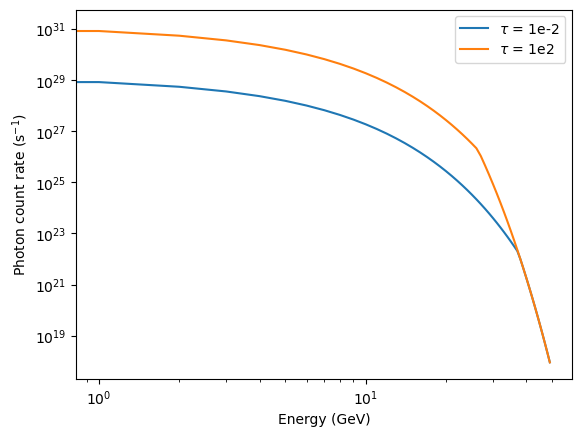

In [361]:
E = np.logspace(0,6)

plt.loglog(photon_flux(E, [Tbh_tau(1e-2)]), label = r'$\tau$ = 1e-2')
plt.loglog(photon_flux(E, [Tbh_tau(1e2)]), label = r'$\tau$ = 1e2')
plt.legend()
plt.xlabel('Energy (GeV)')
plt.ylabel('Photon count rate (s$^{-1}$)')

In [377]:
Ebkg = lambda E: 1.4*1e-6 * E**(-2.1) #cm-2 GeV-1 s-1 sr-1

frej = 1e-5 # background rejection

def CRbkg(Egamma):
    zz = [1]*len(Egamma)
    for i in range(len(Egamma)):
        zz[i] = max( frej * 1.2*7900*1e-4* Egamma[i]**-2.65,  Ebkg(Egamma[i]))
    return zz

In [461]:
# Proper motion contours
propmo_dat = pd.read_csv('./EffectiveAreas/propermotion.dat', sep=' ', header=None, names = [r'0.1$\circ$ proper motion', r'1$\circ$', r'10$\circ$'])
def log_interp(x,y):
    lin = interp1d(np.log10(x), np.log10(y), kind='linear', fill_value='extrapolate')
    return lambda z: 10**lin(np.log10(z))

In [462]:
year = 365 * 24 * 60 * 60

def detN(Egamma, tau, Aeff, dOm, obs_time, tmin = 1e-1):

    return (obs_time/tau) * simps(dOm * Aeff(Egamma) * photon_flux(Egamma, Tbh_tau(tau)), x = Egamma)

def detSN(sig, Egamma, Aeff, dOm, obs_time):
    noise = np.sqrt( obs_time * simps(dOm * Aeff(Egamma) * CRbkg(Egamma), x = Egamma) )
    return sig/noise

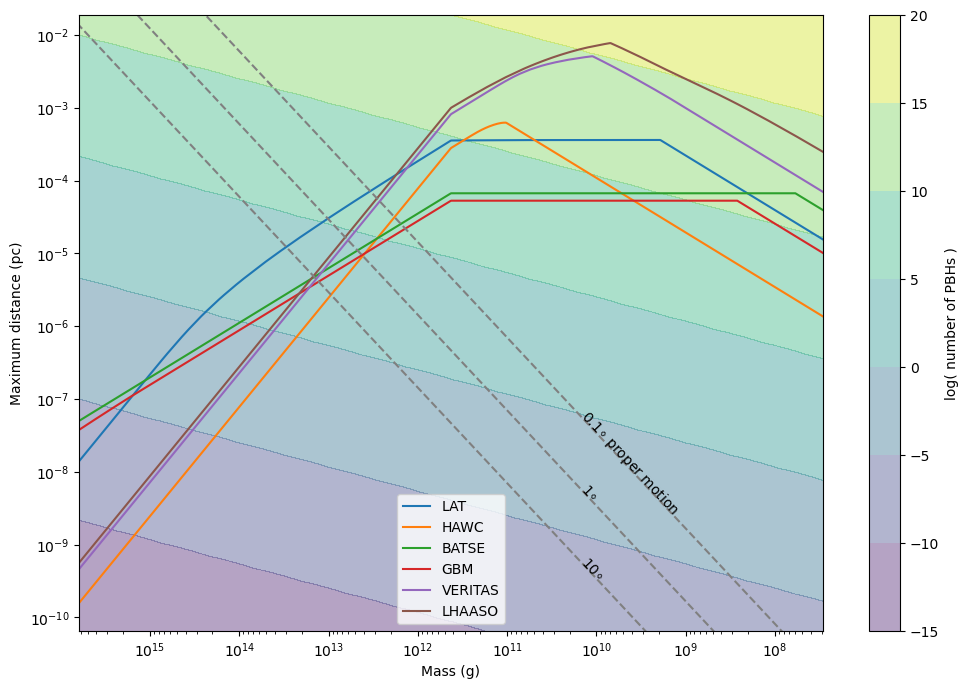

In [465]:
fig, ax = plt.subplots( figsize = (12,8) )

for i,detector in enumerate(EffectiveAreas):

    # Ranges and interpolation
    Erange = np.logspace(Eranges[detector][0], Eranges[detector][1])
    Om = dOm[detector]
    Aeff = interp1d( x = EffectiveAreas[detector]['E GeV'], y = EffectiveAreas[detector]['Aeff cm2'], kind='linear', bounds_error = False, fill_value = 0. )

    #mass = np.logspace(8, 15, 1_000)
    remaining_lifetime = np.logspace(-5, 20, 1_000)
    tmin = remaining_lifetime[0]

    max_dist = []
    for tau in remaining_lifetime:
        
        # Either obs duration or remaining lifetime
        obs_time = min(year, tau)

        N = detN(Erange, tau, Aeff, Om, obs_time, tmin) / (4 * 3.14159) # let d=1 to just cancel out
        Ns = detSN(N, Erange, Aeff, Om, obs_time) / (4 * 3.14159)
        max_dist.append( min(
            np.sqrt( N/10 ) * u.cm.to('pc'),
            np.sqrt( Ns/5 ) * u.cm.to('pc'),
                ) )
    
    #ax.loglog(remaining_lifetime, max_dist, color = 'C%s'%i, label = detector)
    mass = Mbh(remaining_lifetime)
    ax.loglog(mass, max_dist, color = 'C%s'%i, label = detector)

# Keep track of axes
ylim = ax.get_ylim()

# Show proper motion contours
for i in range(3):
    x = propmo_dat.index
    y = propmo_dat.iloc[:,i]
    #ax.loglog(x,y,'--',color='grey')
    ax.loglog(mass, log_interp(x,y)(mass), color = 'grey', linestyle = '--')
    ax.text(1.5e10, log_interp(x, y)(1.5e10), propmo_dat.columns[i], rotation = -47, rotation_mode = 'anchor')

# Show population density
M,D = np.meshgrid(mass, np.logspace(np.log10(ylim[0]), np.log10(ylim[1])))
# sigma = 1
# Mstar = 1e10
# im = ax.contourf( M, D, np.log10(numberDensity(M,D,Mstar,sigma)) , alpha = .4)#, levels = [-15, -10, -5, 0, 5, 10, 15] )
# cb = plt.colorbar(im, label = 'log( number of PBHs )')
monochromatic_npbh = lambda dist, mass, rhoDM=.3, fPBH=1 : rhoDM * fPBH / (mass * 5.62e23) * (4/3*3.14159) * (dist * 3.086e18)**3
im = ax.contourf(M, D, np.log10(monochromatic_npbh(D, M)), alpha = .4)#, levels = [-15, -10, -5, 0, 5, 10, 15] )
cb = plt.colorbar(im, label = 'log( number of PBHs )')

ax.legend()
#plt.xlabel('Time (s)')
ax.set_xlabel('Mass (g)')
ax.set_ylabel('Maximum distance (pc)')
ax.set_ylim(*ylim)
xlim = ax.get_xlim()
ax.set_xlim(xlim[-1], xlim[0])
ax.set_yticks([1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10])

fig.savefig('Detection_distance_curves.png')